# Tree-based Methods
## Decision Trees, Random Forests, Gradient Boosted Decision Trees

The objective for this notebook is to take a high-level look at some of the tools available for tree-based models in scikit-learn

```
conda update scikit-learn
```

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

# Data

Today we will use the boston housing data. Each row is a neighborhood. The features correspond to properties of houses in that neighborhood (e.g. average number of rooms). The target is the mean price (in \$1Ks) for that neighborhood

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

In [5]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [9]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Keep track of predictors and target

In [10]:
predictors = boston.feature_names
target = 'Price'

### Train/Test Split

In [27]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df)

In [28]:
train_test_split?

In [29]:
train_df.shape

(379, 14)

In [30]:
test_df.shape

(127, 14)

# Decision Tree

A decision tree uses _recursive binary splits_ to segment the data into disjoint subsets. The splits are chosen according to _impurity_. For regression problems, impurity usually mean variance. For classification, impurity could mean entropy or gini impurity.

In [39]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=3)

Fit to the training data

In [40]:
dt.fit(train_df[predictors], train_df[target])

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

### Visualize the tree

```
pip install pydotplus
brew install graphviz
```

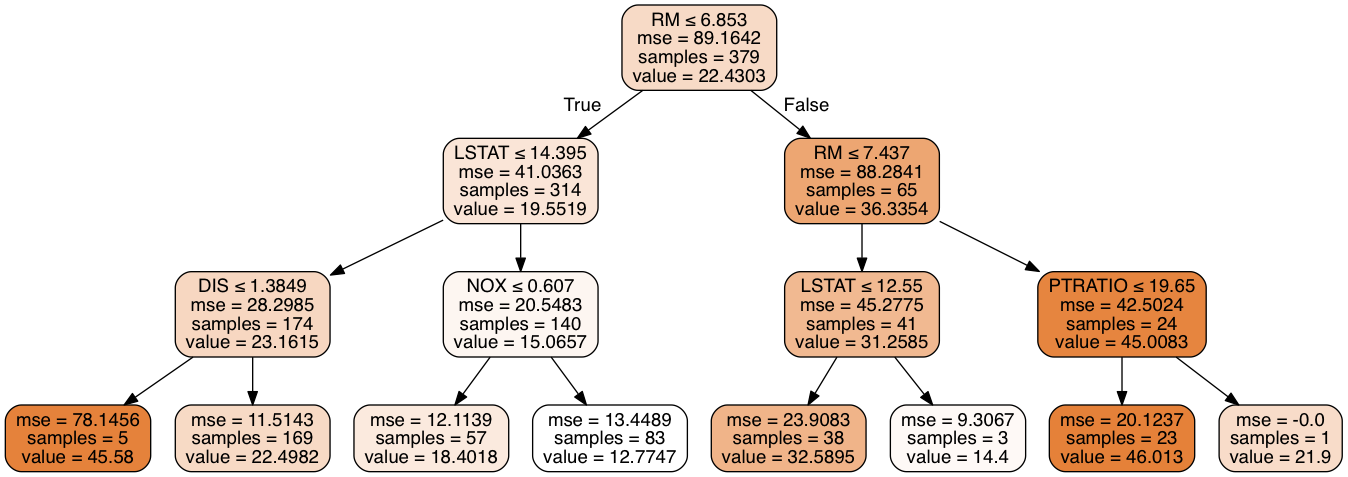

In [41]:
from IPython.display import Image  
from sklearn import tree
import pydotplus
dot_data = tree.export_graphviz(dt, out_file='tmp.dot',
                                feature_names=predictors,  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file('tmp.dot')
Image(graph.create_png())  

### Accuracy on training data

Mean-squared error

mean((actual - pred) ** 2)

In [42]:
actual = train_df[target]
pred = dt.predict(train_df[predictors])
mse = np.mean((actual - pred) ** 2)
mse

14.624448643580761

R-squared

In [44]:
dt.score(train_df[predictors], train_df[target])

0.8359829024043286

### Cross-validation Score

__Exercise__: We would like to get a better estimate of the decision tree performance, but without contaminating the test data. Try using cross-validation to estimate the performance of the decision tree

In [46]:
cross_val_score?

In [48]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, train_df[predictors], train_df[target], cv=10)
scores.mean()

0.72857161049204122

### Grid Search CV

Sklearn doesn't allow _post-pruning_ of decision trees, but we can try some pre-pruning parameters

In [52]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor()
parameter_grid = {'max_depth': [2, 3, 4, 5, 6]}
searcher = GridSearchCV(dt, param_grid=parameter_grid, cv=10)
searcher.fit(train_df[predictors], train_df[target])

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [53]:
searcher.best_params_

{'max_depth': 5}

In [54]:
searcher.best_score_

0.76737777384834593

#### Double check we get the same answer

### Fit the best parameters to the full training data

In [55]:
dt = DecisionTreeRegressor(**searcher.best_params_)  
dt.fit(train_df[predictors], train_df[target])

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

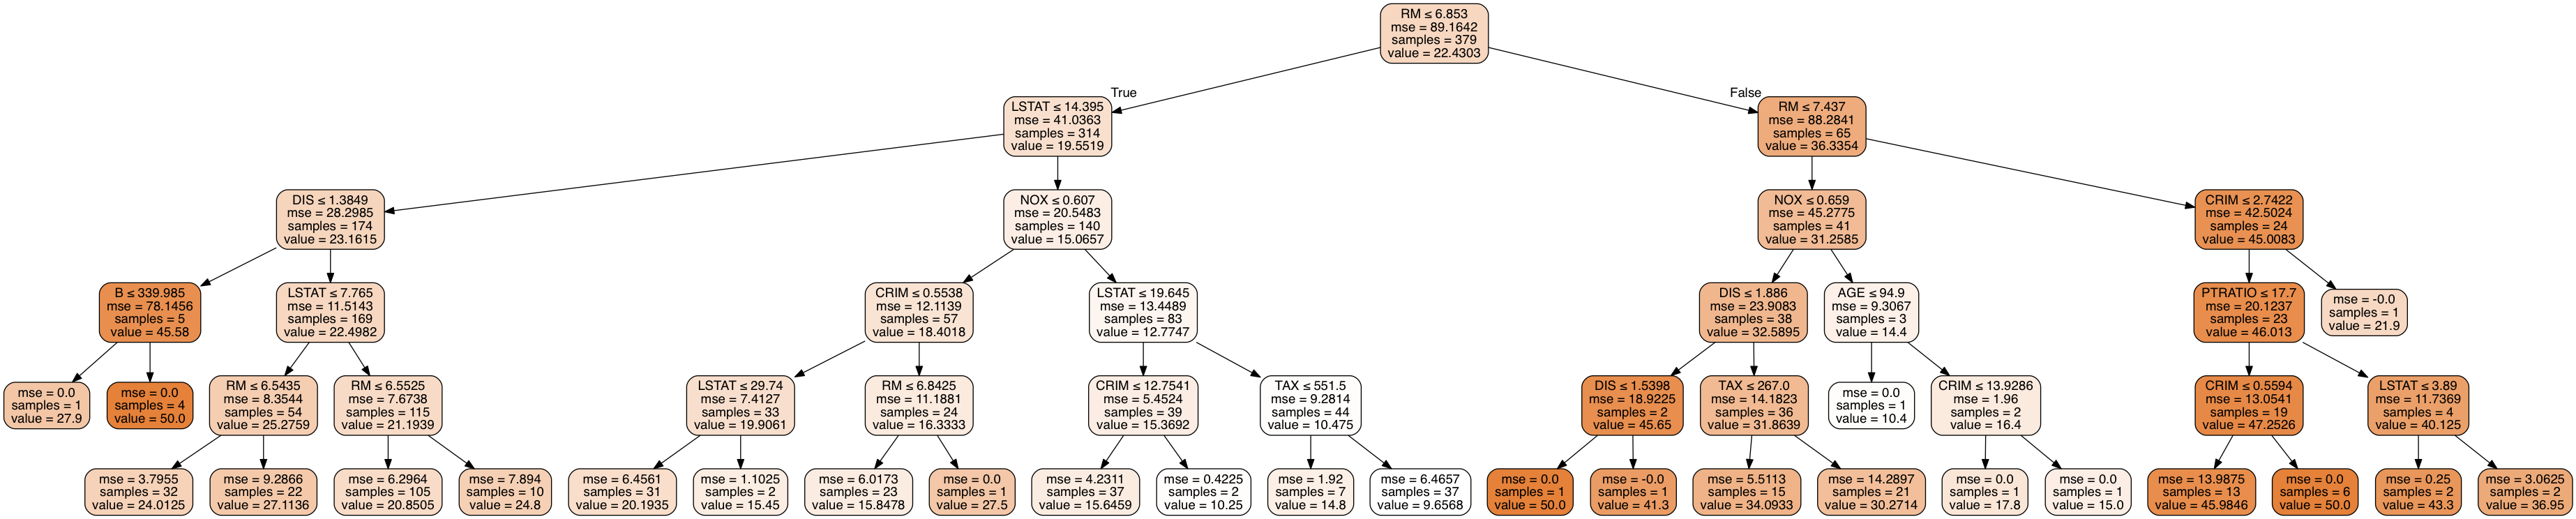

In [56]:
dot_data = tree.export_graphviz(dt, out_file='tmp.dot',
                                feature_names=predictors,  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file('tmp.dot')
Image(graph.create_png())  

## Random Forest

A random forest consists of N independently trained decision trees. The trees then vote on their final prediction

Random Forests are _very_ robust to parameter choices. Rules of thumb:
- Individual trees should be grown as deep as possible (lowering bias)
- Trees need to be _decorrelated_. Usually this is achieved just by bootstrapping (automatic) and choosing a subset of features at each split.
- You need 'enough' trees. 100-500 is probably fine

Build a random forest and get cross-validated error on the training set

In [63]:
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
225,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,50.0
23,0.98843,0.0,8.14,0.0,0.538,5.813,100.0,4.0952,4.0,307.0,21.0,394.54,19.88,14.5
91,0.03932,0.0,3.41,0.0,0.489,6.405,73.9,3.0921,2.0,270.0,17.8,393.55,8.20,22.0
377,9.82349,0.0,18.10,0.0,0.671,6.794,98.8,1.3580,24.0,666.0,20.2,396.90,21.24,13.3
398,38.35180,0.0,18.10,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0


In [69]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, max_features=3, oob_score=True)
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print scores
print scores.mean()

[ 0.91324509  0.90366456  0.84498554  0.88722254  0.72073478  0.92396509
  0.77324215  0.89419684  0.91231213  0.8017441 ]
0.857531280256


### Out-of-bag performance

Random forests come with a built in way to estimate performance on unseen data _without the need for cross-validation_.

Since each tree only sees a subset of the data (a bootstrap sample), each data point can be assigned an _oob prediction_ based only on the trees that it was not used to construct

In [70]:
rf.fit(train_df[predictors], train_df[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [71]:
print "Train R^2: {:.3}".format(rf.score(train_df[predictors], train_df[target]))
print "OOB R^2: {:.3}".format(rf.oob_score_)

Train R^2: 0.982
OOB R^2: 0.866


### Interpretation

#### Feature Importance

Every time a split is made in any tree in the forest, that split contributes to the overall information gain of the model. We can keep track of the total information gain attributed to each feature in the model.

/Users/zalexander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


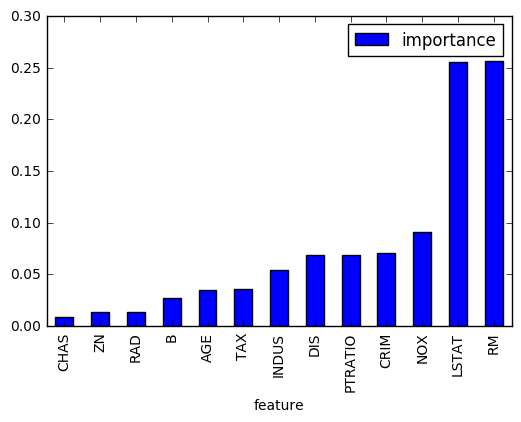

In [76]:
import_df = pd.DataFrame({
        'importance': rf.feature_importances_,
        'feature': predictors
        })
import_df.sort('importance').plot(x='feature', kind='bar')

#### Decision Paths

For any one prediction, we can follow that prediction down each tree to see how each feature has contributed to that particular prediction

```
pip install treeinterpreter
```

prediction = bias + sum(contributions)

__Exercise__:

1. Find the five most expensive neighborhoods in the training data, _according to the model_
2. Tell the story of 1-2 of the neighborhoods. Why are they so expensive (according to the model).

Neighborhoods 1,3,4, and 5 are pretty similar. They all consist of really large houses in upper-class neighborhoods. Neighborhood 2 is a little different. It is much smaller, but it is expensive because of its proximity to the city center.

## Gradient Boosting

- Gradient boosting works by building one tree at a time. 
- Each successive tree is targeted on the gradient of the loss of the model up to that point. For regression, this means that each tree is targeted on the residual of the previous trees.
- If subsample < 1 and/or max_features < n_features, then it becomes stochastic gradient boosting.
- The main parameters are
    - max_depth: Also called interaction depth. This controls the bias of the individual estimators.
    - learning_rate: the weight applied to each successive tree
    - n_estimators: number of iterations.
    - max_features: the number of features available at each split

(0.2, 1)

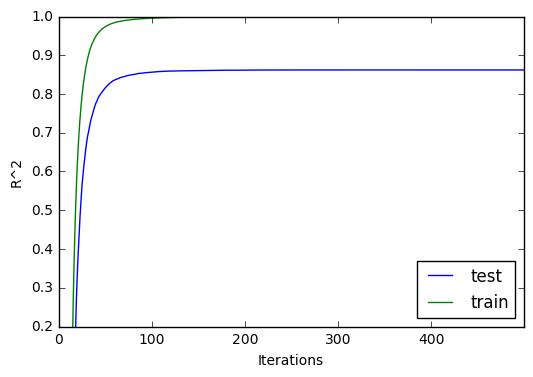

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import pdb

gb = GradientBoostingRegressor(subsample=.7, max_depth=6, learning_rate = .05, 
                               n_estimators=500, max_features='auto')


# Split train_df
train, dev = train_test_split(train_df)

# Function to retrieve sequence of accuracies at each boosting iteration
def get_accuracy(train, dev):
    train_acc = []
    test_acc = []
    for x, y in zip(gb.staged_predict(train[predictors]), gb.staged_predict(dev[predictors])):
        train_acc.append(r2_score(x, train[target]))
        test_acc.append(r2_score(y, dev[target]))
    return train_acc, test_acc

# Get the full sequence of accuracies for each of 10-fold
kf = KFold(n_splits=10)
train_accuracies = []
test_accuracies = []
for train_idx, dev_idx in kf.split(train_df):
    train = train_df.iloc[train_idx]
    dev = train_df.iloc[dev_idx]
    gb.fit(train[predictors], train[target])
    train_acc, test_acc = get_accuracy(train, dev)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
train_acc = np.mean(np.array(train_accuracies), axis=0)
test_acc = np.mean(np.array(test_accuracies), axis=0)

# Plot
d = pd.DataFrame({
        'train': train_acc,
        'test': test_acc
        })
d.plot()
plt.xlabel('Iterations')
plt.ylabel('R^2')
plt.ylim([.2, 1])

### Exercise: Grid-search for best GB model

1. Use cross-validation to perform a grid search over GBDT parameters (you can choose any set of parameters)
2. Build a GBDT model on all the data using the best set of parameters

In [79]:
gb = GradientBoostingRegressor(subsample=.7, max_depth=6, learning_rate = .05, 
                               n_estimators=500, max_features='auto')
gb.fit(train_df[predictors], train_df[target])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=0.7, verbose=0, warm_start=False)

Best parameters

Best score

#### Best Model

### Feature Importance

/Users/zalexander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


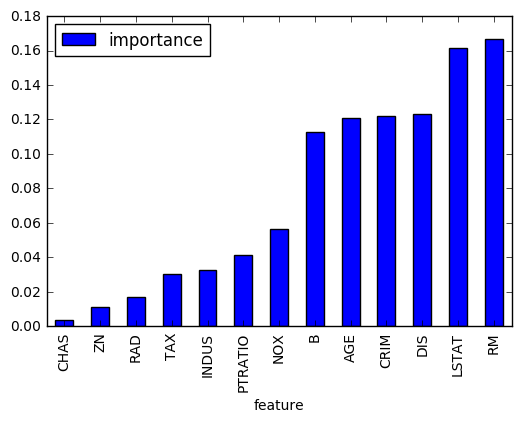

In [80]:
import_df = pd.DataFrame({
        'importance': gb.feature_importances_,
        'feature': predictors
        })
import_df.sort('importance').plot(x='feature', kind='bar')

## Try all three models on the test set

In [81]:
dt.score(test_df[predictors], test_df[target])

0.83808223388227021

In [82]:
rf.score(test_df[predictors], test_df[target])

0.90637700242080865

In [83]:
gb.score(test_df[predictors], test_df[target])

0.91753705585405465